In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from numba import jit, cuda
from sklearn.metrics import silhouette_score

In [2]:
ctu13 = pd.read_csv('~/Desktop/My_files/S-4_SS21/Project/DataExploration/complete_all_scenarios_NoTransfer_withHeader_withLabel-29-8-2021-bak.csv')

/home/sudip/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
ctu13_1 = ctu13

# Replace the label of normal traffic with 0
ctu13_1.loc[ctu13_1['Label'].str.contains('Normal') == True, 'Label'] = 0

# Replace the label of abnormal/botnet traffic with 1
ctu13_1.loc[ctu13_1['Label'].str.contains('Botnet') == True, 'Label'] = 1

In [4]:
# ctu13_1.to_csv(r'/home/sudip/PycharmProjects/pythonProject/binLabel.csv')
ctu13_1

,Dur,SrcDur,DstDur,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,SrcRate,DstRate,sMaxPktSz,sMinPktSz,dMaxPktSz,dMinPktSz,Label,Dir+AF8- +AC0APg-,Dir+AF8- +ADwALQA+-,Dir+AF8- +ADw-?+AD4-
0,0,0.0,0.0,63,63.0,1,1.0,1,1,0,...,0.000000,0.000000,141,141,135.0,135.0,0,1,0,0
1,0,0.0,0.0,63,63.0,1,1.0,1,1,0,...,0.000000,0.000000,247,247,135.0,135.0,0,1,0,0
2,0,0.0,0.0,63,63.0,1,1.0,1,1,0,...,0.000000,0.000000,173,173,135.0,135.0,0,1,0,0
3,0.000291,0.0,0.0,63,63.0,1,1.0,2,1,1,...,0.000000,0.000000,72,72,135.0,135.0,0,0,1,0
4,0.000321,0.0,0.0,63,63.0,1,1.0,2,1,1,...,0.000000,0.000000,72,72,175.0,175.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513591,0.01823,0.01823,0.009056,63,53.0,1,11.0,6,4,2,...,164.563904,110.424026,74,66,74.0,66.0,0,1,0,0
513592,0.018535,0.018535,0.009478,63,53.0,1,11.0,6,4,2,...,161.855957,105.507492,74,66,74.0,66.0,0,1,0,0
513593,0.202575,0.177784,0.177919,63,53.0,1,11.0,10,5,5,...,22.499212,22.482141,277,66,398.0,66.0,0,1,0,0
513594,0.018334,0.018334,0.009244,63,53.0,1,11.0,6,4,2,...,163.630417,108.178284,74,66,74.0,66.0,0,1,0,0


In [42]:
def dataset_cleaning (dataset):
    dataset = dataset.iloc[:,0:-4]
    for col in dataset.columns: #conver all values to number.(in the case any string is included)
        dataset[col]= pd.to_numeric(dataset[col],errors='coerce') #the error value force to put Nan if there is any error to convert string to value
        #dataset=dataset.dropna() # remove nan *Dropping the nans removes the corresponding rows as well, which would letter affect our data indices.
    dataset.fillna(dataset.median(), inplace=True) # Instead of dropping, fills NaNs with median vals
    scaler = MinMaxScaler()
    
    return pd.DataFrame(scaler.fit_transform(dataset))

sklearn.impute.SimpleImputer can also impute the NaN values with const, mean, med or mode. [example](https://github.com/ajhalthor/scikit-learn-pipeline/blob/main/Pipeline.ipynb)

In [44]:
# data_columns = ['Dur', 'SrcDur', 'DstDur']
# ctu13_2 = (ctu13_1.drop(data_columns, axis=1).join(ctu13_1[data_columns].apply(pd.to_numeric, errors='coerce')))

ctu13_scaled = dataset_cleaning(ctu13)
ctu13_scaled_ol = pd.concat([ctu13_scaled, ctu13_1['Label']], axis=1)
# ctu13_scaled_ol.to_csv(r'/home/sudip/PycharmProjects/pythonProject/scaledWOldLabels.csv')
ctu13_scaled_ol

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,Label
0,0.000000e+00,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000000,0.000006,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.055708,0.055708,0.051582,0.051582,0
1,0.000000e+00,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000000,0.000006,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.128611,0.128611,0.051582,0.051582,0
2,0.000000e+00,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000000,0.000006,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.077717,0.077717,0.051582,0.051582,0
3,8.083334e-08,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000004,0.000006,0.000006,...,0.000000,0.000000,0.013746,0.000000,0.000000,0.008253,0.008253,0.051582,0.051582,0
4,8.916667e-08,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000004,0.000006,0.000006,...,0.000000,0.000000,0.012461,0.000000,0.000000,0.008253,0.008253,0.079092,0.079092,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513591,5.063889e-06,0.000005,0.000003,0.488189,0.199187,0.043478,0.139241,0.000021,0.000023,0.000011,...,0.000560,0.000234,0.001097,0.000658,0.000221,0.009629,0.004127,0.009629,0.004127,0
513592,5.148611e-06,0.000005,0.000003,0.488189,0.199187,0.043478,0.139241,0.000021,0.000023,0.000011,...,0.000550,0.000224,0.001079,0.000647,0.000211,0.009629,0.004127,0.009629,0.004127,0
513593,5.627084e-05,0.000049,0.000049,0.488189,0.199187,0.043478,0.139241,0.000038,0.000028,0.000028,...,0.000124,0.000091,0.000178,0.000090,0.000045,0.149243,0.004127,0.232462,0.004127,0
513594,5.092778e-06,0.000005,0.000003,0.488189,0.199187,0.043478,0.139241,0.000021,0.000023,0.000011,...,0.000556,0.000229,0.001091,0.000655,0.000216,0.009629,0.004127,0.009629,0.004127,0


In [ ]:
# total = ctu13_2.isnull().sum().sort_values(ascending=False)
# percent = (ctu13_2.isnull().sum()/ctu13_2.isnull().count()).sort_values(ascending=False)
# missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(6)

In [ ]:
# ctu13_2.fillna(ctu13_2.median(), inplace=True)

In [ ]:
# ctu13_scaled = MinMaxScaler().fit_transform(ctu13_2)

**Determining the optimal K**
<br>**Methods:** [ref](https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad)
* Elbow method
* Silhouette Scoring
* Calinski-Harabasz Index
* Davies-Bouldin Index  
    The time complexity of the Silhouette index computation is much greater than the time complexity of the Davies-Bouldin index computation. But performancewise Silhouette is better. [ref](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.102.4114&rep=rep1&type=pdf).
* Dendrogram (used for agglomerative hierarchical method of clustering)
* Bayesian information criterion (used for Gaussian Mixture Modeling)



In [45]:
# Elbow method
wcss = [] # Within Cluster Squared Sum

for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = np.random.RandomState(0), max_iter=3000)
    kmeans.fit(ctu13_scaled) 
    wcss.append(kmeans.inertia_)

**Silhouette Scoring**
<br>[Ref for sample size silhouette_score](https://stackoverflow.com/questions/23687247/efficient-k-means-evaluation-with-silhouette-score-in-sklearn)

The silhouette value represents how similar a datapoint is to its own cluster when compared to all the other clusters or cluster centroids. The value ranges from -1 to +1. A higher silhouette value implies that the datapoint is matched well to its own centroid/cluster. [ref](https://arxiv.org/ftp/arxiv/papers/1912/1912.00643.pdf)

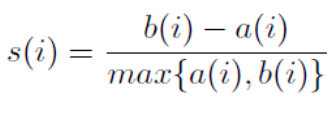 
a(i) = Mean intra-cluster distance 
<br>b(i) = Mean nearest-cluster distance 

In [46]:

import timeit
# Silhouette Scoring method
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
def calc_silhScore (df, kmax, n_smpl_sz):
    start = timeit.default_timer()
    sil = []
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = np.random.RandomState(0), max_iter=3000).fit(df)
        labels = kmeans.labels_
        sil.append(silhouette_score(df, labels, metric = 'euclidean', sample_size=n_smpl_sz))
    stop = timeit.default_timer()
    print(f'Execution time with {n_smpl_sz} samples: ', stop - start)
    return sil

sil_1000 = calc_silhScore(ctu13_scaled, 10, 1000)
sil_5000 = calc_silhScore(ctu13_scaled, 10, 5000)
sil_10000 = calc_silhScore(ctu13_scaled, 10, 10000)
# sil_all = calc_silhScore(ctu13_scaled, 10, None)

Execution time with 1000 samples:  55.113890299006016
Execution time with 5000 samples:  57.44545482599642
Execution time with 10000 samples:  61.29613248499663


NameError: name 'sil_all' is not defined

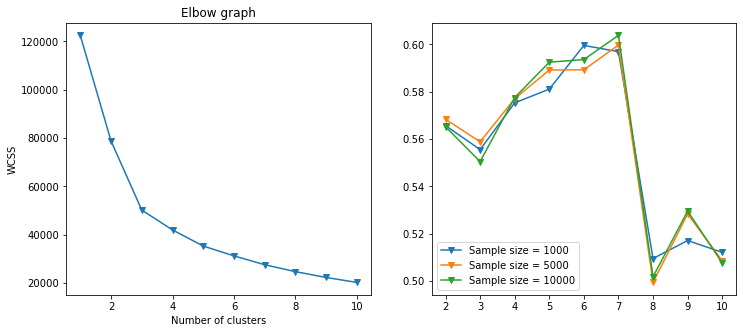

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# Plot Elbow graph
ax1.plot(range(1, 11), wcss, marker='v')
ax1.set_title("Elbow graph")
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')


# Plot Silhouette Scores
def plotCollection(ax, xs, ys, *args, **kwargs):
    ax.plot(xs,ys, *args, **kwargs)
    
    if "label" in kwargs.keys():
        #remove duplicates
        handles, labels = plt.gca().get_legend_handles_labels()
        newLabels, newHandles = [], []
        for handle, label in zip(handles, labels):
            if label not in newLabels:
                newLabels.append(label)
                newHandles.append(handle)

    plt.legend(newHandles, newLabels)

plotCollection(ax2, range(2, 11), sil_1000, marker='v', label="Sample size = 1000")
plotCollection(ax2, range(2, 11), sil_5000, marker='v', label="Sample size = 5000")
plotCollection(ax2, range(2, 11), sil_10000, marker='v', label="Sample size = 10000")
plotCollection(ax2, range(2, 11), sil_all, marker='v', label="Whole dataset", color= 'k')
ax2.set_title("Silhouette Score Comparison")
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('silhouette score')

plt.show()

**Calinski-Harabasz Index** [ref](https://iopscience.iop.org/article/10.1088/1757-899X/569/5/052024/pdf)
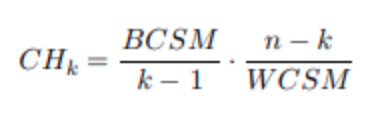
BCSM (between cluster scatter matrix) = calculates separation between clusters
<br>WCSM (within cluster scatter matrix) = calculates compactness within clusters.

* Advantages [ref](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index)
    * The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

    * The score is fast to compute.

* Drawbacks
    * The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [ ]:
# # Calinski Harabasz Score for K means
# # Import ElbowVisualizer
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans(init= 'k-means++', random_state=42)
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,10),metric='calinski_harabasz', timings= True)
# visualizer.fit(ctu13_scaled)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

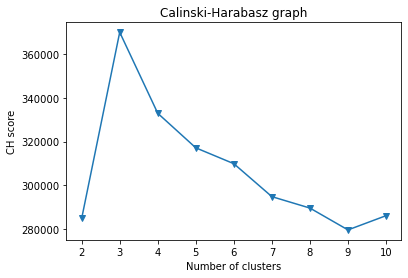

In [48]:
# Calinski-Harabasz scoring method
CH = []
for k in range(2, 11):
    kmeans_model = KMeans(n_clusters=k, random_state=42).fit(ctu13_scaled)
    labels = kmeans_model.labels_
    CH.append(metrics.calinski_harabasz_score(ctu13_scaled, labels))

# Plot Calinski-Harabasz
plt.plot(range(2, 11), CH, marker='v')
plt.title("Calinski-Harabasz graph")
plt.xlabel('Number of clusters')
plt.ylabel('CH score')
plt.show()

In [59]:
# Apply K-Means
kmeans = KMeans(
    init="k-means++",
    n_clusters=7,
    random_state = 1034, max_iter=3000
)
ctu13_transformed = kmeans.fit_transform(ctu13_scaled)

In [ ]:
# pd.DataFrame(ctu13_transformed).to_csv(r'/home/sudip/PycharmProjects/pythonProject/ctu13_transformed.csv')

In [ ]:
centers = kmeans.cluster_centers_

**Dimensionality reduction with PCA and 2d and 3d plot**
[ref](https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6)

In [ ]:
from sklearn.decomposition import PCA

# Dimesionality reduction to 2
pca_model = PCA(n_components=2)
pca2=pca_model.fit(ctu13_scaled) # fit the model
pca2d = pca2.transform(ctu13_scaled) # transform the 'normalized model'
# transform the 'centroids of KMean'
centroid_pca = pca_model.transform(centers)
print(centroid_pca)

In [ ]:
# 2D plot with PCA dimentionality reduction 
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=kmeans.labels_, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (3) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [ ]:
# 2D plot with PCA dimentionality reduction with original Labels 
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=ctu13_1['Label'], 
                palette='Set1',
                s=100, alpha=0.2).set_title('Scatter plot of dataset with original labels', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [ ]:
ctu13_transformed

In [ ]:
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

In [ ]:
# 3d scatterplot using plotly 
Scene = dict(xaxis = dict(title  = 'C1'),yaxis = dict(title  = 'C2'),zaxis = dict(title  = 'C3'))

trace = go.Scatter3d(x=ctu13_transformed[:, 0], y=ctu13_transformed[:, 1], z=ctu13_transformed[:, 2], mode='markers',marker=dict(color = kmeans.labels_, size= 2, line=dict(color= 'black',width = 0)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()


In [ ]:
# Reduce dimensions and 3D-plot according to true Labels

from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

# Dimesionality reduction to 3
pca_model = PCA(n_components=3)
pca3=pca_model.fit(ctu13_scaled) # fit the model
pca3d = pca3.transform(ctu13_scaled) # transform the 'normalized model'


# 3d scatterplot using plotly 
Scene = dict(xaxis = dict(title  = 'Pc1'),
             yaxis = dict(title  = 'Pc2'),
             zaxis = dict(title  = 'Pc3'))

trace = go.Scatter3d(x=pca3d[:, 0], 
                     y=pca3d[:, 1], 
                     z=pca3d[:, 2], 
                     mode='markers',
                     marker=dict(color = kmeans.labels_, 
                                 size= 2, 
                                 line=dict(color= 'black',width = 0)
                                )
                    )
layout = go.Layout(margin=dict(l=0,r=0),
                   scene = Scene,
                   height = 800,
                   width = 800)
data = [trace]
fig = go.Figure(data = data, 
                layout = layout)
fig.show()


In [60]:
from sklearn.metrics import pairwise_distances_argmin as pda

In [61]:
# label the dataset according to k-means clustering
def get_new_label (df_scaled, labels, n_clusters):
    
    # concat old Labels with scaled data 
    df_wl = pd.concat([df_scaled, labels], axis=1)
    
    # gets the cluster numbers of all of kmeans and converts to df
    x=pd.DataFrame(data=np.resize(kmeans.labels_, (len(kmeans.labels_),1)), columns=["Cluster no."]) 

    # concatinate the cluster number to the dataframe
    df_n_cl = pd.concat([df_wl, x], axis=1) 
    
    # get indexes of nodes at minimum distances from their clusters centers
    min_dist = pda(kmeans.cluster_centers_, df_scaled, metric='euclidean')

    # propagate label of center nodes
    df_n_cl['new_label']=labels
    for k in range(n_clusters):
        # get the old label of the node nearest to the corresponding center node
        label_center_node = df_n_cl.iloc[min_dist[k], df_n_cl.columns.get_loc("Label")] 

        # fill new_label with label of k where cluster number == k
        df_n_cl['new_label']=df_n_cl['new_label'].mask(df_n_cl['Cluster no.']==k,label_center_node)
    
    return df_n_cl

# get_new_label(ctu13_scaled, ctu13_1['Label'], 2).to_csv('ctu13_WnewLabels.csv')
ctu13_WnewLabels = get_new_label(ctu13_scaled, ctu13_1['Label'], 3)

In [63]:
ctu13_WnewLabels

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,Label,Cluster no.,new_label
0,0.000000e+00,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000000,0.000006,0.000000,...,0.000000,0.000000,0.000000,0.055708,0.055708,0.051582,0.051582,0,6,0
1,0.000000e+00,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000000,0.000006,0.000000,...,0.000000,0.000000,0.000000,0.128611,0.128611,0.051582,0.051582,0,6,0
2,0.000000e+00,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000000,0.000006,0.000000,...,0.000000,0.000000,0.000000,0.077717,0.077717,0.051582,0.051582,0,6,0
3,8.083334e-08,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000004,0.000006,0.000006,...,0.013746,0.000000,0.000000,0.008253,0.008253,0.051582,0.051582,0,6,0
4,8.916667e-08,0.000000,0.000000,0.488189,0.239837,0.043478,0.012658,0.000004,0.000006,0.000006,...,0.012461,0.000000,0.000000,0.008253,0.008253,0.079092,0.079092,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513591,5.063889e-06,0.000005,0.000003,0.488189,0.199187,0.043478,0.139241,0.000021,0.000023,0.000011,...,0.001097,0.000658,0.000221,0.009629,0.004127,0.009629,0.004127,0,6,0
513592,5.148611e-06,0.000005,0.000003,0.488189,0.199187,0.043478,0.139241,0.000021,0.000023,0.000011,...,0.001079,0.000647,0.000211,0.009629,0.004127,0.009629,0.004127,0,6,0
513593,5.627084e-05,0.000049,0.000049,0.488189,0.199187,0.043478,0.139241,0.000038,0.000028,0.000028,...,0.000178,0.000090,0.000045,0.149243,0.004127,0.232462,0.004127,0,0,0
513594,5.092778e-06,0.000005,0.000003,0.488189,0.199187,0.043478,0.139241,0.000021,0.000023,0.000011,...,0.001091,0.000655,0.000216,0.009629,0.004127,0.009629,0.004127,0,6,0


In [62]:
ctu13_WnewLabels.to_csv('ctu13_WnewLabels.csv')


In [ ]:
# Reduce dimensions and 3D-plot according to predicted Labels

from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

# Dimesionality reduction to 3
pca_model = PCA(n_components=3)
pca3=pca_model.fit(ctu13_scaled) # fit the model
pca3d = pca3.transform(ctu13_scaled) # transform the 'normalized model'


# 3d scatterplot using plotly 
Scene = dict(xaxis = dict(title  = 'Pc1'),
             yaxis = dict(title  = 'Pc2'),
             zaxis = dict(title  = 'Pc3'))

trace = go.Scatter3d(x=pca3d[:, 0], 
                     y=pca3d[:, 1], 
                     z=pca3d[:, 2], 
                     mode='markers',
                     marker=dict(color = ctu13_WnewLabels['new_label'], 
                                 size= 2, 
                                 line=dict(color= 'black',width = 0)
                                )
                    )
layout = go.Layout(margin=dict(l=0,r=0),
                   scene = Scene,
                   height = 800,
                   width = 800)
data = [trace]
fig = go.Figure(data = data, 
                layout = layout)
fig.show()


What is DBSCAN?
1. [ref-1](http://madhugnadig.com/articles/machine-learning/2017/08/23/understanding-dbscan-and-scikit-implementation-machine-learning.html)
2. [ref-2](https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html)

Finding the optimal value of eps-[ref](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc)
<br>
Hyper param selection[ref](https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62)
*[Knee locator](https://gist.github.com/Vini2/7a2740a4ced1f2dcda9d2899deff465f#file-dbscan-blog-ipynb)

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

ctu13_sampled = ctu13_scaled.sample(frac=.01)
neigh = NearestNeighbors(radius=0.5,
                        metric = 'euclidean')
neigh.fit(ctu13_sampled)
dist_mat=neigh.radius_neighbors_graph(ctu13_sampled,
                                      mode = "distance")

In [8]:
db = DBSCAN(eps=0.5,
           min_samples=10,
           metric='precomputed')

db.fit_(dist_mat)

/home/sudip/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:175: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


DBSCAN(metric='precomputed', min_samples=10)

In [24]:
pd.DataFrame(db.labels_).to_csv('db_label.csv')



In [33]:
from sklearn.decomposition import PCA

# Dimesionality reduction to 3
pca_model = PCA(n_components=3)
pca3=pca_model.fit(ctu13_sampled) # fit the model
pca3d = pca3.transform(ctu13_sampled) # transform the 'normalized model'


# 3d scatterplot using plotly 
import plotly.express as px

fig = px.scatter_3d(x=pca3d[:, 0],
                    y=pca3d[:, 1],
                    z=pca3d[:, 2],
                    color=db.labels_
                   )
fig.update_traces(marker=dict(size=2))
fig.show()
